In [24]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.xls') or filename.endswith('.xlsx'):
        data = pd.read_excel(filename)
        print(data.head())
    else:
        print("Unsupported file format. Please upload an Excel file.")

Saving boo2 sports01.xlsx to boo2 sports01.xlsx
                                             comment target
0     تاکہ ہارنے کے بعد اِن دونوں پر مدہ ڈالا جا سکے    neg
1  انشاءاللہ بھائی تم جیت یا ہمیں تم سے پیار ہےبہ...    pos
2  انڈیا کے ساتھ ایشیا کپ میچ میں  کتنے رنز بنانا...    pos
3  گنگولی کے دیس میں ٹیلنٹ بہت ہے ہمارے ہاں ایسا ...    pos
4  متفق  افراد کو جوڑنا سب کو ضرورت کی جگہ پر  کر...    neu


# Data PreProcessing

In [25]:
!pip install urduhack

In [26]:
!pip install demoji

In [27]:
import re
import string
import nltk
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Activation, LSTM, GRU, Embedding, Bidirectional, InputLayer
from gensim.models import KeyedVectors

from prettytable import PrettyTable
from collections import Counter

import urduhack
urduhack.download()
from urduhack.preprocessing import replace_urls
from urduhack.preprocessing import replace_numbers
from urduhack.preprocessing import remove_punctuation
from urduhack.preprocessing import remove_accents
from urduhack.preprocessing import remove_english_alphabets
from urduhack.preprocessing import normalize_whitespace
from urduhack.models.lemmatizer import lemmatizer
from urduhack.normalization import normalize

import demoji

In [28]:
data.shape

(10004, 2)

In [29]:
data['target'].value_counts()

target
neg    3873
neu    3178
pos    2953
Name: count, dtype: int64

In [30]:
data['comment'].value_counts()

comment
لعنت ایسے کلپ پر                                                                                                               3
آخری بال اس طرح نہیں کراتے بچے                                                                                                 3
کسی ایک میچ میں سکور بنا کر بابر اعظم کا مقابلہ نہیں کر سکتے بابر اعظم گریٹ پلئیر ھے                                           3
آپکا تلفظ اور اردو لہجہ بہت بہت زیادہ خراب ہے آپ کو اچھا کمینٹیٹر نہیں ملتا تو چینل بند کردو یہ پشتو لہجہ میں اردو مت سُناؤ    3
اپنی ب بند کر ثانیہ مرزا کو چھوڑ کر ایک کنجری سے شادی کی ہے تو ایسا نہ مرزا ثنا جاوید طوائف                                    3
                                                                                                                              ..
اگر وہ ٹیسٹ سیریز کھیلتے ہیں تو ہم اس لمحے کو دوبارہ دیکھ سکتے ہیں                                                             1
ہر ایک اب بھی یونوچس سے بھرا ہوا ہے                                                      

In [31]:
def clean_comment(comment):

    comment = demoji.replace(comment,"")

    comment = re.sub(r'@[A-Za-z0-9]+', '', comment)

    comment = re.sub(r'#[A-Za-z0-9]*', '', comment)

    comment = replace_urls(comment,replace_with="")

    comment = replace_numbers(comment,replace_with="")

    comment = remove_accents(comment)

    comment = remove_english_alphabets(comment)

    comment = normalize_whitespace(comment)

    comment = remove_punctuation(comment)

    comment = normalize(comment)

    comment = re.sub(r'\+', '', comment)

    comment = re.sub(r'\=', '', comment)

    return comment

for i in data.index:
    a = data['comment'][i]
    b = clean_comment(a)
    data.loc[[i],['comment']] = b

In [32]:
print('\n')
data.head()

,comment,target
0,تاکہ ہارنے کے بعد ان دونوں پر مدہ ڈالا جا سکے,neg
1,انشاءاللہ بھائی تم جیت یا ہمیں تم سے پیار ہےبہ...,pos
2,انڈیا کے ساتھ ایشیا کپ میچ میں کتنے رنز بنانا ...,pos
3,گنگولی کے دیس میں ٹیلنٹ بہت ہے ہمارے ہاں ایسا ...,pos
4,متفق افراد کو جوڑنا سب کو ضرورت کی جگہ پر کرنا...,neu


In [33]:
stop_words = set("""             """.split())

def remove_stopwords(text):
    filtered_words = [word for word in text.split() if word not in stop_words]
    return " ".join(filtered_words)

In [34]:
data["comment"] = data.comment.map(remove_stopwords)

In [35]:
def lemitizeStr(text):
    lemme_txt = ""
    temp = lemmatizer.lemma_lookup(text)
    for t in temp:
        lemme_txt += t[0] + " "

    return lemme_txt

In [36]:
data["comment"] = data.comment.map(lemitizeStr)

In [37]:
print('\n')
data.head()

,comment,target
0,تاکہ ہارنے کے بعد ان دونوں پر مدہ ڈالا جا سکے,neg
1,انشاءاللہ بھائی تم جیت یا ہمیں تم سے پیار ہےبہ...,pos
2,انڈیا کے ساتھ ایشیا کپ میچ میں کتنے رنز بنانا ...,pos
3,گنگولی کے دیس میں ٹیلنٹ بہت ہے ہمارے ہاں ایسا ...,pos
4,متفق افراد کو جوڑنا سب کو ضرورت کی جگہ پر کرنا...,neu


GRU

In [38]:
import pandas as pd
from datetime import datetime

# Preprocess the data and save it
# Assuming the preprocessing steps are performed here and stored in the variable 'data'

# Generate a timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define the filename for the preprocessed data
filename = f"preprocessed_data_{timestamp}.xlsx"

# Save the preprocessed data to a known location
file_path = f"{filename}"
data.to_excel(file_path, index=False)

# Print the location of the saved file
print("Preprocessed data saved to:", file_path)



Preprocessed data saved to: preprocessed_data_20240520_061542.xlsx


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, GRU, Dense
from google.colab import files
import pandas as pd

file_path = "preprocessed_data_20240520_051516.xlsx"  # Specify the path to your file
train_data = pd.read_excel(file_path)


# Prepare the data
X = data['comment']
y = data['target']

# Tokenize the text
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Pad sequences
maxlen = 100
X = pad_sequences(X, maxlen=maxlen)

# Convert labels to one-hot encoded vectors
num_classes = 3  # Assuming 3 classes for sentiment analysis
y = pd.get_dummies(y).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the GRU model
embedding_dim = 100
gru_units = 128

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(GRU(gru_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model.summary())

# Train the model
batch_size = 128
epochs = 20
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 gru_1 (GRU)                 (None, 128)               88320     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1088707 (4.15 MB)
Trainable params: 1088707 (4.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
63/63 [==============================] - 53s 748ms/step - loss: 1.

In [40]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shapes of X_test and y_test
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (2001, 100)
Shape of y_test: (2001, 3)


In [41]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

63/63 [==============================] - 5s 77ms/step - loss: 0.4845 - accuracy: 0.9160
Test Loss: 0.4845484495162964
Test Accuracy: 0.9160419702529907


63/63 [==============================] - 3s 34ms/step


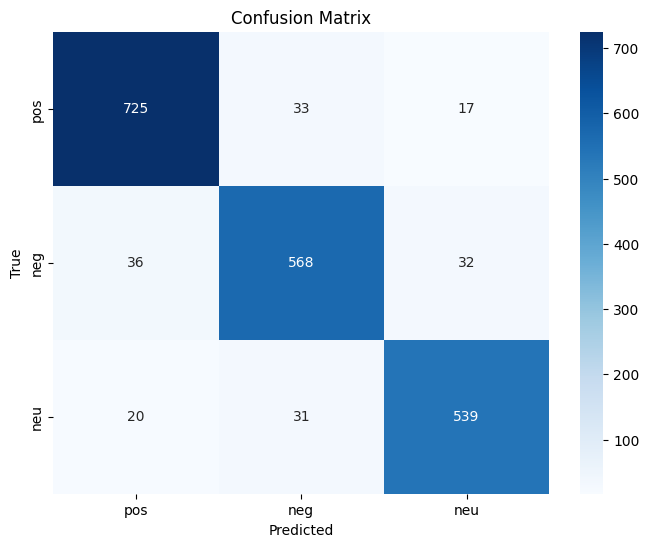

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your code for creating and visualizing the confusion matrix goes here


# Predictions
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Assign true labels for the test set
test_labels_np = y_test

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_np.argmax(axis=1), y_pred_binary.argmax(axis=1), labels=range(3))
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['pos', 'neg', 'neu'], yticklabels=['pos', 'neg', 'neu'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [43]:
import pandas as pd
from datetime import datetime
import os

# Assume train_data is your DataFrame from the Excel file
# Perform preprocessing and model training here

# Define the directory to save the trained model and Excel file
save_dir = "/path/to/save/location/"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Generate a timestamp for the filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define the filenames
model_filename = f"trained_model_{timestamp}.h5"
excel_filename = f"test_data_{timestamp}.xlsx"

# Save the trained model to the specified directory
model.save(os.path.join(save_dir, model_filename))

# Print the location of the saved model
model_file_path = os.path.join(save_dir, model_filename)
print("Trained model saved to:", model_file_path)

# Now, save the preprocessed data to an Excel file in the same directory
data.to_excel(os.path.join(save_dir, excel_filename), index=False)

# Print the location of the saved Excel file
excel_file_path = os.path.join(save_dir, excel_filename)
print("Excel file saved to:", excel_file_path)


Trained model saved to: /path/to/save/location/trained_model_20240520_063921.h5
Excel file saved to: /path/to/save/location/test_data_20240520_063921.xlsx


# Feature Extraction

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data from the Excel file
data = pd.read_excel('/path/to/save/location/test_data_20240520_063921.xlsx')

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save the training and testing data to separate Excel files
train_data.to_excel('train_text.xlsx', index=False)
test_data.to_excel('test_text.xlsx', index=False)


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the training and testing text data
train_data = pd.read_excel('train_text.xlsx')
test_data = pd.read_excel('test_text.xlsx')

# Extract the text data and labels from the training and testing sets
train_text = train_data['comment']
test_text = test_data['comment']
train_labels = train_data[['target']]
test_labels = test_data[['target']]

# Create a TF-IDF vectorizer
max_feature_num = 16500
vectorizer = TfidfVectorizer(max_features=max_feature_num, ngram_range=(1, 1))

# Fit the vectorizer on the training text and transform the training text into TF-IDF vectors
train_vecs = vectorizer.fit_transform(train_text)

# Transform the testing text into TF-IDF vectors
test_vecs = vectorizer.transform(test_text)

# Now train_vecs and test_vecs contain the TF-IDF vectors representing the training and testing text data, respectively


# Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Create a Multilabel Naive Bayes classifier
classifier = MultiOutputClassifier(MultinomialNB())

# Define the hyperparameter grid for grid search
param_grid = {
    'estimator__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for MultinomialNB
    'estimator__fit_prior': [True, False],  # Use class prior probabilities or not for MultinomialNB
}

# Define the evaluation metrics for grid search
scoring = {
    'Accuracy Score': make_scorer(accuracy_score)  # You can change 'macro' to 'micro' or 'weighted'
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy Score')
grid_search.fit(train_vecs, train_labels)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
predictions = best_model.predict(test_vecs)
accuracy = accuracy_score(test_labels, predictions)
# accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: ", accuracy)





Accuracy:  0.6121939030484758


Confusion Matrix:
[[285 241 228]
 [258 201 184]
 [247 175 182]]


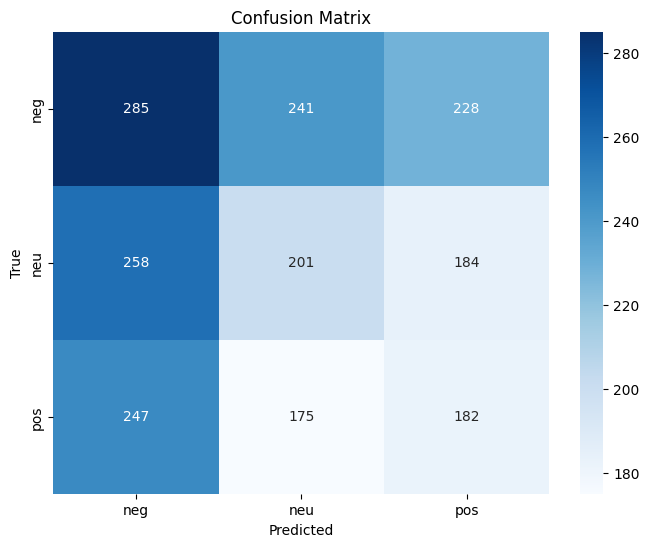


Classification Report:
               precision    recall  f1-score   support

         pos       0.67      0.68      0.68       780
         neg       0.54      0.54      0.54       617
         neu       0.64      0.63      0.64       604

    accuracy                           0.62      2001
   macro avg       0.62      0.62      0.62      2001
weighted avg       0.62      0.62      0.62      2001



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_labels and predictions are generated from the same dataset
# Check and align the lengths of train_labels and predictions
min_length = min(len(train_labels), len(predictions))
train_labels = train_labels[:min_length]
predictions = predictions[:min_length]

# Define target names
target_names = ['neg', 'neu', 'pos']

# Print confusion matrix
conf_matrix = confusion_matrix(train_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(test_labels_np, predictions, target_names=['pos', 'neg', 'neu'])
print("\nClassification Report:\n", class_report)





# Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, hamming_loss, jaccard_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Create a multilabel classifier using Logistic Regression
classifier = MultiOutputClassifier(LogisticRegression(max_iter=20000,class_weight='balanced'))

# Define the hyperparameter grid for grid search
param_grid = {
    'estimator__C': [0.01, 0.1, 1.0, 10.0],  # Regularization parameter (smaller values for stronger regularization)
    'estimator__solver': ['liblinear', 'lbfgs']
}
# Define the evaluation metrics for grid search (you can add more metrics if needed)
scoring = {
    'Accuracy Score': make_scorer(accuracy_score),
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy Score')
grid_search.fit(train_vecs, train_labels)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
predictions = best_model.predict(test_vecs)
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy", accuracy)
test_labels_np = test_labels.to_numpy()



Accuracy 0.6216891554222889


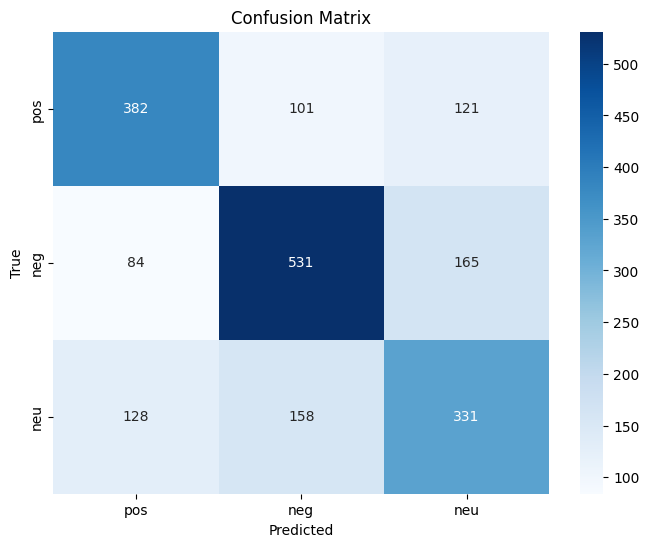


Classification Report:
               precision    recall  f1-score   support

         pos       0.67      0.68      0.68       780
         neg       0.54      0.54      0.54       617
         neu       0.64      0.63      0.64       604

    accuracy                           0.62      2001
   macro avg       0.62      0.62      0.62      2001
weighted avg       0.62      0.62      0.62      2001



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions, labels=['pos', 'neg', 'neu'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['pos', 'neg', 'neu'], yticklabels=['pos', 'neg', 'neu'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(test_labels_np, predictions, target_names=['pos', 'neg', 'neu'])
print("\nClassification Report:\n", class_report)


# SVM

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train One-vs-Rest SVMs
from sklearn.svm import LinearSVC

svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(train_vecs, train_labels)

svmPreds = svmClassifier.predict(test_vecs)
accuracy = accuracy_score(test_labels, svmPreds)
print("Accuracy: ",accuracy)
test_labels_np = test_labels.to_numpy()


Accuracy:  0.6156921539230384


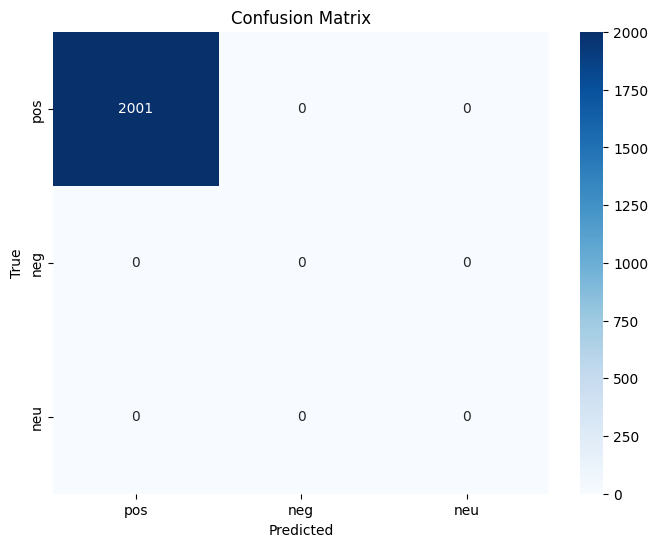


Classification Report:
               precision    recall  f1-score   support

         pos       0.67      0.68      0.68       780
         neg       0.54      0.54      0.54       617
         neu       0.64      0.63      0.64       604

    accuracy                           0.62      2001
   macro avg       0.62      0.62      0.62      2001
weighted avg       0.62      0.62      0.62      2001



In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_np.argmax(axis=1), predictions.argmax(axis=1), labels=range(3))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['pos', 'neg', 'neu'], yticklabels=['pos', 'neg', 'neu'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(test_labels_np, predictions, target_names=['pos', 'neg', 'neu'])
print("\nClassification Report:\n", class_report)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
model = KNeighborsClassifier(n_neighbors = 25)
model.fit(train_vecs, train_labels)
dt_knn=model.predict(test_vecs)
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts=
result_knn=cross_val_score(model,train_vecs,train_labels,cv=kfold,scoring='accuracy')
print('The overall score for K Nearest Neighbors Classifier is:',round(result_knn.mean()*100,2))
y_pred = cross_val_predict(model,test_vecs,test_labels,cv=10)
test_labels_np = test_labels.to_numpy()



The overall score for K Nearest Neighbors Classifier is: 57.83


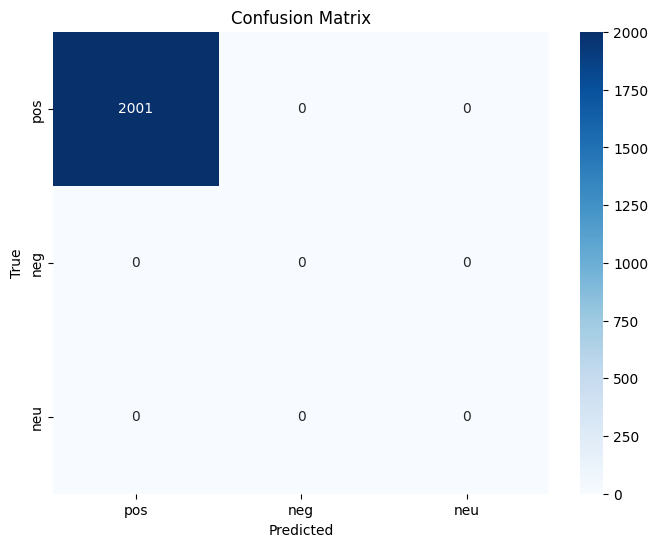


Classification Report:
               precision    recall  f1-score   support

         pos       0.67      0.68      0.68       780
         neg       0.54      0.54      0.54       617
         neu       0.64      0.63      0.64       604

    accuracy                           0.62      2001
   macro avg       0.62      0.62      0.62      2001
weighted avg       0.62      0.62      0.62      2001



In [ ]:

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_np.argmax(axis=1), predictions.argmax(axis=1), labels=range(3))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['pos', 'neg', 'neu'], yticklabels=['pos', 'neg', 'neu'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
class_report = classification_report(test_labels_np, predictions, target_names=['pos', 'neg', 'neu'])
print("\nClassification Report:\n", class_report)